lg 품질 감지

여러가지 시도


In [ ]:
# from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torch.utils.data import Dataset, DataLoader


import torch
import torch.nn as nn
import torch.optim as optim

import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive

drive.mount('/content/drive')


PATH = '/content/drive/My Drive/Colab Notebooks/data/시스템품질변화/'

Mounted at /content/drive


In [ ]:

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('ggplot') # default plot style.

from scipy import stats
from scipy.stats import norm


from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 



In [ ]:
train_err  = pd.read_csv(PATH+'train/train_err_data.csv')
train_quality  = pd.read_csv(PATH+'train/train_quality_data.csv')
train_problem  = pd.read_csv(PATH+'train/train_problem_data.csv')
# submission  = pd.read_csv(PATH+'sample_submission.csv ')

test_err  = pd.read_csv(PATH+'test/test_err_data.csv')
test_quality  = pd.read_csv(PATH+'test/test_quality_data.csv')

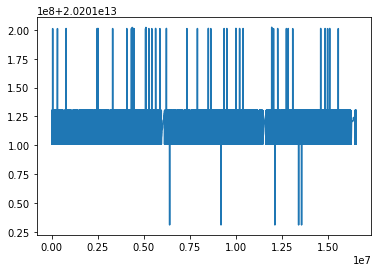

In [ ]:
plt.plot(train_err["time"])

In [ ]:
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [ ]:
train_problem.head()

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


In [ ]:
train_err.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      int64 
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(3), object(3)
memory usage: 757.8+ MB


In [ ]:
user_id = 10006
for user_id in set(train_problem["user_id"]):
  display(
  train_err.loc[(train_err["user_id"] == user_id) &
              (train_err["time"] <train_problem.loc[train_problem["user_id"] == user_id].iloc[0]["time"])].iloc[-30:]
  )

  display(train_problem.loc[train_problem["user_id"] == user_id].iloc[:]["time"])

  temp = train_err.loc[(train_err["user_id"] == user_id) &
              (train_err["time"] <train_problem.loc[train_problem["user_id"] == user_id].iloc[0]["time"])]

,user_id,time,model_nm,fwver,errtype,errcode
4900,10006,20201109144238,model_1,04.16.3553,34,1
4901,10006,20201109144238,model_1,04.16.3553,16,1
4902,10006,20201109144238,model_1,04.16.3553,34,1
4903,10006,20201109144238,model_1,04.16.3553,31,1
4904,10006,20201109144253,model_1,04.16.3553,31,0
4905,10006,20201109164544,model_1,04.16.3553,34,1
4906,10006,20201109164546,model_1,04.16.3553,34,1
4907,10006,20201109164548,model_1,04.16.3553,34,1
4908,10006,20201109164549,model_1,04.16.3553,34,1
4909,10006,20201109164550,model_1,04.16.3553,15,1


414     20201110170000
3826    20201110180000
3939    20201113160000
Name: time, dtype: int64

In [ ]:
for i in range(1):
  print(set(train_err.loc[train_err['model_nm'] == f'model_{i}',"errcode"]))

{'76', '8087', '5843', '5215', '8059', '11886', '10980', '3376', '3500', '118518', '5478', '3747', '5924', '3200', '3824', '3386', '31398', '6778', '5813', '3203', '3672', '5497', '5972', '3498', '3391', '5459', '36541', '3197', '5863', '3079', '3075', '5287', '5431', '6048', '95', '5860', '8077', '3270', '3514', '5694', '3084', '5411', '3980', '3048', '5555', '8944', '5768', '36506', '5714', '3538', '3059', '3565', '10190', '3669', '3420', 'P-44010 ', '5688', '3129', '3074', '5429', '3823', '77', 'U-82026', '3744', '3098', '3977', '6042', '5792', '3288', '4478', '3783', '21725', '41376', '3275', '5584', '5559', '3578', '8851', '20868', '3128', '3967', '20920', '3251', '14', '72038', '5393', '5974', '3558', '3310', '5421', '4807', 'connectionterminated by local host', '5407', '5502', '3301', '5629', '5465', '5542', '5854', '3065', '5510', '3132', '5646', '3250', '5978', '3532', '5915', '6030', '5826', '1', '3325', '3360', '5894', '3723', '3987', '5744', '3691', '3110', '6711', '2', 'st

In [ ]:
temp["errcode"][-30:]

4282    connection timeout
4283                     1
4284    connection timeout
4285                     1
4286    connection timeout
4287                     1
4288    connection timeout
4289    connection timeout
4290                     1
4291                     1
4292                     1
4293                     1
4294                     0
4295    connection timeout
4296                     1
4297                     1
4298    connection timeout
4299            NFANDROID2
4300    connection timeout
4301                     1
4302    connection timeout
4303                     1
4304                     1
4305                     1
4306                     2
4307                     1
4308                     1
4309                     1
4310                     1
4311                     1
Name: errcode, dtype: object

## data setting

In [ ]:
def func(user_id):

  display(train_err.loc[train_err["user_id"] == user_id])
  # display(train_quality.loc[train_quality["user_id"] == user_id])
  display(train_problem.loc[train_problem["user_id"] == user_id])
  train_err.loc[(train_err["user_id"] == user_id) & (train_err["time"] <train_problem.loc[train_problem["user_id"] == user_id][-1]["time"])]
# display(train_quality.loc[train_quality["user_id"]==10003])

func(10004)

In [ ]:
set(train_err["model_nm"])

{'model_0',
 'model_1',
 'model_2',
 'model_3',
 'model_4',
 'model_5',
 'model_6',
 'model_7',
 'model_8'}

In [ ]:
# group by

train_err_group = train_err.groupby(['user_id']).count().sort_values(by=['time'])[["model_nm"]]
train_problem_group= train_problem.groupby(['user_id']).count().sort_values(by=['time'])

In [ ]:
train_err.groupby(['user_id']).count()

,time,model_nm,fwver,errtype,errcode
user_id,,,,,
10000,317,317,317,317,317
10001,2365,2365,2365,2365,2365
10002,306,306,306,306,306
10003,306,306,306,306,306
10004,777,777,777,777,777
...,...,...,...,...,...
24995,194,194,194,194,194
24996,4,4,4,4,4
24997,826,826,826,826,826


모델별 err count

In [ ]:
temp = train_err.groupby([train_err['user_id'],train_err['model_nm']]).mean()

temp.reset_index(level=1, inplace=True)
temp.reset_index(level=0, inplace=True)
temp.drop(columns=["time",'errtype'],inplace=True)
user_model = temp
display(temp[:35])

display(temp.groupby(temp['model_nm']).count())
temp2 = temp.groupby(temp['user_id']).count()

print("\n\n\n모델 두개이상 가진 user")
display(temp2[temp2['model_nm']!=1].sort_values(by="model_nm",ascending=False))

,user_id,model_nm
0,10000,model_3
1,10001,model_2
2,10002,model_3
3,10003,model_2
4,10004,model_0
5,10005,model_0
6,10006,model_1
7,10006,model_2
8,10007,model_0
9,10008,model_0


,user_id
model_nm,
model_0,4360
model_1,2842
model_2,4493
model_3,3105
model_4,689
model_5,40
model_6,66
model_7,61
model_8,48





모델 두개이상 가진 user


,model_nm
user_id,
18525,3
10006,2
20189,2
19976,2
20001,2
...,...
15256,2
15272,2
15293,2


In [ ]:
train_problem.sort_values(by= "user_id")

,user_id,time
1116,10001,20201113190000
492,10004,20201104120000
3857,10005,20201113120000
3826,10006,20201110180000
414,10006,20201110170000
...,...,...
3870,24983,20201123230000
2378,24984,20201130150000
3829,24990,20201121170000
2799,24997,20201115150000


In [ ]:
have_2models = set(temp2[temp2['model_nm']!=1].sort_values(by="model_nm",ascending=False).index)

모델이 2개이상인사람은 90%이상 접수했다. 

아무래도 모델 두개있있고 에러두배로뜨니까 대충 그런거겠지?



In [ ]:
print(len(train_problem))
print(len(set(train_problem["user_id"])))
print(len(set(train_problem["user_id"]) - have_2models))

5429
5000
4357


모델 한개인사람들 

In [ ]:
train_problem_have1model = train_problem.loc[train_problem["user_id"].isin((set(train_problem["user_id"]) - have_2models))].sort_values(by = "user_id")

In [ ]:
temp = train_err.groupby([train_err['user_id'],train_err['model_nm']]).mean()

temp.reset_index(level=1, inplace=True)
temp.reset_index(level=0, inplace=True)
temp.drop(columns=["time",'errtype'],inplace=True)

display(train_problem_have1model)
display(temp)

,user_id,time
1116,10001,20201113190000
492,10004,20201104120000
3857,10005,20201113120000
4243,10008,20201124130000
4735,10009,20201125150000
...,...,...
403,24983,20201123220000
3870,24983,20201123230000
3829,24990,20201121170000
2799,24997,20201115150000


,user_id,model_nm
0,10000,model_3
1,10001,model_2
2,10002,model_3
3,10003,model_2
4,10004,model_0
...,...,...
15699,24995,model_2
15700,24996,model_3
15701,24997,model_0
15702,24998,model_0


In [ ]:
problem = pd.merge(train_problem_have1model, temp,how='left', on = 'user_id')
display(problem)
problem.groupby(problem["model_nm"]).count()




,user_id,time,model_nm
0,10001,20201113190000,model_2
1,10004,20201104120000,model_0
2,10005,20201113120000,model_0
3,10008,20201124130000,model_0
4,10009,20201125150000,model_1
...,...,...,...
4704,24983,20201123220000,model_0
4705,24983,20201123230000,model_0
4706,24990,20201121170000,model_4
4707,24997,20201115150000,model_0


,user_id,time
model_nm,,
model_0,1763,1763
model_1,785,785
model_2,1204,1204
model_3,728,728
model_4,144,144
model_5,22,22
model_6,10,10
model_7,30,30
model_8,23,23


In [ ]:
train_err_group

,model_nm
user_id,
15605,1
21076,1
12367,1
12470,1
13525,1
...,...
11041,66093
20352,83680
15570,175730


In [ ]:
train_problem.loc[train_problem["user_id"]== 11041]

,user_id,time


In [ ]:
train_quality

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0
828620,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0
828621,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0
828622,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0


In [ ]:
len(set(train_quality["user_id"]) -set(train_problem["user_id"]))

5114

In [ ]:
 set(train_problem["user_id"]) - set(train_err["user_id"])

set()

15000명 중에 

8천명이 problem quanlity

5천명이 문제있다고 답함

둘은 꼭 부분집합 관계는 아님


In [ ]:
temp = train_err_group.join(train_problem_group,how='left')

In [ ]:
temp.fillna(0,inplace=True)

In [ ]:
temp.sort_values(by=['time'],ascending=False)

,model_nm,time
user_id,,
24407,1910,5.0
24138,564,4.0
11016,607,4.0
11528,544,4.0
20636,1563,4.0
...,...,...
23030,356,0.0
12226,695,0.0
12706,695,0.0


In [ ]:
temp.rename(columns = {'time' : 'target','model_nm' : 'count'}, inplace = True)


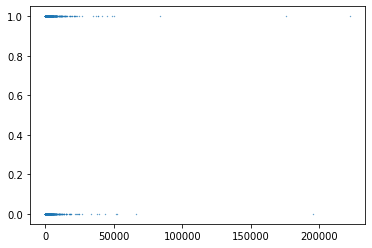

In [ ]:
plt.scatter(temp['count'],temp['target'].apply(lambda x : 1 if x >1 else x ),s = 0.1)

##dataset

In [ ]:
X = temp.iloc[:, 0:-1]
y = temp.iloc[:, -1]

In [ ]:
# Train - Test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69)

scaler

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

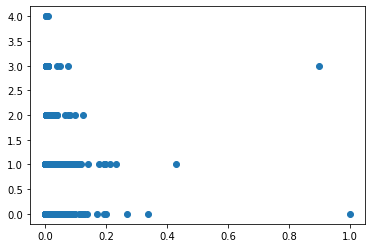

In [ ]:
plt.scatter(X_train,y_train)

In [ ]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())

In [ ]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

In [ ]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

## 해볼거 : model 0 번껄로 접수하기전에 여러가지 테스트해보자


1. 모델 여러개 가진 사용자는 일단 삭제하자

In [ ]:
train_err[['user_id','model_nm']].groupby([train_err['user_id'],train_err['model_nm']]).mean()

,,user_id
user_id,model_nm,
10000,model_3,10000
10001,model_2,10001
10002,model_3,10002
10003,model_2,10003
10004,model_0,10004
...,...,...
24995,model_2,24995
24996,model_3,24996
24997,model_0,24997
